In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import plotly.express as px
import scipy.stats as stats
import folium
import folium.plugins as fol_plugins
import branca.colormap as branca_folium_cm
import warnings
from pprint import pprint
 
warnings.filterwarnings('ignore')
 
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rc('axes', unicode_minus=False)
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', None)

In [2]:
# 히트맵 함수 정의
def drawing_heatmap(df: pd.DataFrame, column: str, radius: int=8, colormap: str=None) -> folium.Map:
    my_map = folium.Map(location=(36, 127), zoom_start=7)
    data = df[['위도', '경도', column]]
    data['value'] = (df[column]-df[column].min())/(df[column].max()-df[column].min()) + .05
    data.drop(columns=column, inplace=True)
    data = data.values.tolist()
    if colormap=='red':
        color_dict = {.1: '#ffeaea', .3:'#ff3f3f', .7:'#ab0000', 1: '#490000'}
    elif colormap=='blue':
        color_dict = {.1: '#cfe2fc', .3:'#9fc6f9', .7:'#6ea9f7', 1: '#2350D9'}
    else:
        color_dict = {.1: 'blue', .3: 'lime', .7: 'orange', 1: 'red'}

    hm = fol_plugins.HeatMap(
        data,
        gradient=color_dict,
        min_opacity=.6,
        max_opacity=.8,
        radius=radius,
        use_local_extrema=False)
    my_map.add_child(hm)
    return my_map

# 원형 마커 함수 정의
def drawing_circle(df: pd.DataFrame, column: str,radius: int=8, colormap: str='YlOrRd') -> folium.Map:
    my_map = folium.Map(location=(36, 127), zoom_start=7)
    data = df[['위도', '경도', column]]
    data['value'] = (df[column] - df[column].min()) / (df[column].max() - df[column].min()) + .05
    data.drop(columns=column, inplace=True)
    data = data.values.tolist()

    colormap = branca_folium_cm.LinearColormap(colors=['blue', 'green', 'yellow', 'red'], vmin=0, vmax=1)
    for point in data:
        folium.Circle(
            location=(point[0], point[1]),
            radius=point[2] * radius * 1000,
            color=colormap(point[2]),
            fill=True,
            fill_color=colormap(point[2])
        ).add_to(my_map)
    colormap.add_to(my_map)
    return my_map

# 꺽쇠 제거 함수 정의
def remove_angle_bracket(data: pd.DataFrame, column: str) -> None:
    data[column] = data[column].str.replace('<', '')
    data[data[column].isin(('-', '불검출'))] = 0
    data[column] = data[column].astype(float)

## 조업일 어종조업정보 

In [3]:
merge_data =  pd.read_csv('조업일_어종조업정보_오류처리.csv')

In [4]:
merge_data

,어업종류,어구종류이름,조업대상어종,해구도번호,조업일자,위도,경도,개체수
0,근해안강망어업,근해안강망,갈치,220,2020-10-31 17:00:00,33.770510,125.269840,28
1,근해안강망어업,근해안강망,조기,218,2020-10-31 04:20:00,33.756832,124.262850,20
2,근해안강망어업,근해안강망,갈치,219,2020-10-31 18:00:00,33.740902,124.760280,28
3,근해안강망어업,근해안강망,갈치,220,2020-10-31 04:20:00,33.770510,125.269840,28
4,근해안강망어업,근해안강망,갈치,221,2020-10-31 04:20:00,33.757282,125.771690,28
...,...,...,...,...,...,...,...,...
55848,근해유자망어업,참조기유자망,갈치,202,2022-04-04 04:30:00,34.050632,123.693476,75
55849,근해유자망어업,참조기유자망,갈치,212,2022-04-04 04:30:00,34.235844,126.287677,75
55850,근해유자망어업,참조기유자망,갈치,219,2022-04-04 04:30:00,33.753381,124.719884,75
55851,근해유자망어업,참조기유자망,갈치,222,2022-04-04 04:30:00,33.916190,124.863114,75


In [5]:
print(merge_data.shape)
print('*' * 30)
display(merge_data.head())

(55853, 8)
******************************


,어업종류,어구종류이름,조업대상어종,해구도번호,조업일자,위도,경도,개체수
0,근해안강망어업,근해안강망,갈치,220,2020-10-31 17:00:00,33.770510,125.26984,28
1,근해안강망어업,근해안강망,조기,218,2020-10-31 04:20:00,33.756832,124.26285,20
2,근해안강망어업,근해안강망,갈치,219,2020-10-31 18:00:00,33.740902,124.76028,28
3,근해안강망어업,근해안강망,갈치,220,2020-10-31 04:20:00,33.770510,125.26984,28
4,근해안강망어업,근해안강망,갈치,221,2020-10-31 04:20:00,33.757282,125.77169,28


# 해양환경측정망 데이터

In [6]:
해양환경측정망 = pd.read_csv('해양환경측정망.csv')

In [7]:
해양환경측정망.head(3)

,년,월,조사일,조사기간,구분,생태구,해역,정점명,기상,수심,수질지수,표층수온,저층수온,표층염분,저층염분,표층pH,저층pH,표층DO,저층DO,표층COD,저층COD,표층NH4-N,저층NH4-N,표층NO2-N,저층NO2-N,표층NO3-N,저층NO3-N,표층DIN,저층DIN,표층T-N,저층T-N,표층DIP,저층DIP,표층T-P,저층T-P,표층SiO2-Si,저층SiO2-Si,표층SS,저층SS,표층chl,저층Chl-a,투명도,기존연안명칭,개략위치 설명,위도,경도
0,2011,2,16,14:36:00,하천영향 및 반폐쇄성해역(B),서해중부,한강하구,BC0101,맑음,11.0,3,1.21,1.19,29.15,29.17,8,8,12.370945,12.454083,4.065152,3.865292,182.100,175.000,10.472,11.914,180.950,204.582,373.522,391.496,876.54042,953.25062,6.169,10.943,100.246753,97.840831,160.132,184.324,79.6,89.2,4.524,3.6016,0.4,인천연안,세어도 북방,37.591667,126.561111
1,2011,2,16,13:49:00,하천영향 및 반폐쇄성해역(B),서해중부,한강하구,BC0102,맑음,18.0,3,1.15,0.96,29.73,29.96,8,8,12.698314,12.442099,2.506244,2.626160,130.188,105.240,13.272,6.104,236.068,129.836,379.528,241.180,756.44170,569.01824,9.920,7.781,92.026519,78.493208,242.844,122.108,88.8,72.8,4.060,3.5960,0.4,인천연안,운겸도 동방,37.537500,126.586111
2,2011,2,16,16:07:00,하천영향 및 반폐쇄성해역(B),서해중부,한강하구,BC0103,맑음,10.0,3,1.13,1.01,29.89,30.01,8,8,12.051115,12.095622,2.466272,2.985908,163.172,155.274,11.550,6.790,218.862,147.392,393.584,309.456,767.49764,840.25144,14.849,16.058,74.884325,62.253234,228.172,144.200,40.0,46.4,3.596,10.7076,0.5,인천연안,만석부두 인근,37.506667,126.584722


In [8]:
# 기본 생태구별 data
대한해협 = pd.read_csv('대한해협_전처리.csv')
서해중부 = pd.read_csv('서해중부_전처리.csv')
동해 = pd.read_csv('동해_전처리.csv')
서남해역 = pd.read_csv('서남해역_전처리.csv')
제주 = pd.read_csv('제주_전처리.csv')


In [9]:
#'기상', '년', '월', '조사일', '조사기간'에 따라 groupby한 생태구별 수질지수 data 
대한해협_수질지수 = pd.read_csv('대한해협_수질지수.csv')
서해중부_수질지수 = pd.read_csv('서해중부_수질지수.csv')
동해_수질지수 = pd.read_csv('동해_수질지수.csv')
서남해역_수질지수 = pd.read_csv('서남해역_수질지수.csv')
제주_수질지수 = pd.read_csv('제주_수질지수.csv')


# Prophet 모델 
- 시계열 모델
- 생태구별 다음 24시간 수질지수 예측

In [10]:
from prophet import Prophet
from datetime import datetime, timedelta

def model_prophet(df):
    # '일자' 날짜 형식 변환
    df['일자'] = pd.to_datetime(df['일자'], errors='coerce', format='mixed')

    # 변환 실패한 행 제거
    df = df.dropna(subset=['일자'])
    
    # df 준비
    data = df[['일자', '수질지수']]
    data.rename(columns={'일자': 'ds', '수질지수': 'y'}, inplace=True)
    
    # Prophet 모델 생성
    model = Prophet()
    
    # model 학습
    model.fit(data)
    
    # 2년뒤 24시간 예측
    future = model.make_future_dataframe(periods=24*365*2, freq='H')
    forecast = model.predict(future)
    
    return forecast.iloc[-(24*365*2):][['ds', 'yhat']][-(24*180):] # 6달치만 보기

In [81]:
대합해협_수질지수_2년뒤 = model_prophet(대한해협_수질지수)
대합해협_수질지수_2년뒤

22:20:32 - cmdstanpy - INFO - Chain [1] start processing
22:20:33 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
20194,2024-05-23 15:34:00,1.749391
20195,2024-05-23 16:34:00,1.650735
20196,2024-05-23 17:34:00,1.825882
20197,2024-05-23 18:34:00,2.448841
20198,2024-05-23 19:34:00,3.328630
...,...,...
24509,2024-11-19 10:34:00,2.231693
24510,2024-11-19 11:34:00,2.151584
24511,2024-11-19 12:34:00,2.114447
24512,2024-11-19 13:34:00,2.156028


In [82]:
서해중부_수질지수_2년뒤 = model_prophet(서해중부_수질지수)
서해중부_수질지수_2년뒤

22:20:38 - cmdstanpy - INFO - Chain [1] start processing
22:20:38 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
16986,2024-05-19 10:50:00,1.792175
16987,2024-05-19 11:50:00,1.771617
16988,2024-05-19 12:50:00,1.691886
16989,2024-05-19 13:50:00,1.612007
16990,2024-05-19 14:50:00,1.624268
...,...,...
21301,2024-11-15 05:50:00,0.935619
21302,2024-11-15 06:50:00,1.595568
21303,2024-11-15 07:50:00,1.865946
21304,2024-11-15 08:50:00,1.875881


In [83]:
동해_수질지수_2년뒤 = model_prophet(동해_수질지수)
동해_수질지수_2년뒤

22:20:43 - cmdstanpy - INFO - Chain [1] start processing
22:20:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
16086,2024-02-21 15:35:00,2.023036
16087,2024-02-21 16:35:00,2.057434
16088,2024-02-21 17:35:00,2.129292
16089,2024-02-21 18:35:00,2.162208
16090,2024-02-21 19:35:00,2.042673
...,...,...
20401,2024-08-19 10:35:00,3.079705
20402,2024-08-19 11:35:00,3.043125
20403,2024-08-19 12:35:00,3.058060
20404,2024-08-19 13:35:00,3.094974


In [84]:
서남해역_수질지수_2년뒤 = model_prophet(서남해역_수질지수)
서남해역_수질지수_2년뒤

22:20:47 - cmdstanpy - INFO - Chain [1] start processing
22:20:47 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
14497,2024-05-20 15:27:00,1.330563
14498,2024-05-20 16:27:00,1.151914
14499,2024-05-20 17:27:00,1.383904
14500,2024-05-20 18:27:00,2.215731
14501,2024-05-20 19:27:00,3.366313
...,...,...
18812,2024-11-16 10:27:00,1.515147
18813,2024-11-16 11:27:00,1.469632
18814,2024-11-16 12:27:00,1.538461
18815,2024-11-16 13:27:00,1.657019


In [85]:
제주_수질지수_2년뒤 = model_prophet(제주_수질지수)
제주_수질지수_2년뒤

22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
14190,2024-05-12 14:20:00,1.093184
14191,2024-05-12 15:20:00,1.129767
14192,2024-05-12 16:20:00,1.096128
14193,2024-05-12 17:20:00,1.020758
14194,2024-05-12 18:20:00,0.947801
...,...,...
18505,2024-11-08 09:20:00,1.367283
18506,2024-11-08 10:20:00,1.480831
18507,2024-11-08 11:20:00,1.515076
18508,2024-11-08 12:20:00,1.533245


In [86]:
대합해협_수질지수_2년뒤.to_csv('대합해협_수질지수_2024_6달치_예측.csv', index=False)
서해중부_수질지수_2년뒤.to_csv('서해중부_수질지수_2024_6달치_예측.csv', index=False)
동해_수질지수_2년뒤.to_csv('동해_수질지수_2024_6달치_예측.csv', index=False)
서남해역_수질지수_2년뒤.to_csv('서남해역_수질지수_2024_6달치_예측.csv', index=False)
제주_수질지수_2년뒤.to_csv('제주_수질지수_2024_6달치_예측.csv', index=False)

## 해역별 어업 데이터

In [10]:
# 조사일 -> 일 변환
대한해협.rename({'조사일':'일'}, axis=1, inplace=True)
서남해역.rename({'조사일':'일'}, axis=1, inplace=True)
동해.rename({'조사일':'일'}, axis=1, inplace=True)
서해중부.rename({'조사일':'일'}, axis=1, inplace=True)
제주.rename({'조사일':'일'}, axis=1, inplace=True)

In [11]:
어업_개체수 = merge_data.copy()
# 조업일자를 datetime 형식으로 변환
어업_개체수['조업일자'] = pd.to_datetime(어업_개체수['조업일자'])

# 어업_개체수 년,월,일 추출
어업_개체수['년'] = 어업_개체수['조업일자'].dt.year
어업_개체수['월'] = 어업_개체수['조업일자'].dt.month
어업_개체수['일'] = 어업_개체수['조업일자'].dt.day

어업_개체수.drop('조업일자', axis=1, inplace=True)

어업_개체수.rename({'위도':'조업_위도', '경도':'조업_경도'}, axis=1, inplace=True)

어업_개체수.head()

,어업종류,어구종류이름,조업대상어종,해구도번호,조업_위도,조업_경도,개체수,년,월,일
0,근해안강망어업,근해안강망,갈치,220,33.770510,125.26984,28,2020,10,31
1,근해안강망어업,근해안강망,조기,218,33.756832,124.26285,20,2020,10,31
2,근해안강망어업,근해안강망,갈치,219,33.740902,124.76028,28,2020,10,31
3,근해안강망어업,근해안강망,갈치,220,33.770510,125.26984,28,2020,10,31
4,근해안강망어업,근해안강망,갈치,221,33.757282,125.77169,28,2020,10,31


In [12]:
def date_int(df):
    df['년'] = df['년'].astype(int)
    df['월'] = df['월'].astype(int)
    df['일'] = df['일'].astype(int)
    return df
# 년,월,일 int 통일
대한해협 = date_int(대한해협)
서남해역 = date_int(서남해역)
동해 = date_int(동해)
서해중부 = date_int(서해중부)
제주 = date_int(제주)


대한해협_어업 = pd.merge(어업_개체수, 대한해협, on=['년', '월', '일'], how='left')
서남해역_어업 = pd.merge(어업_개체수, 서남해역, on=['년', '월', '일'], how='left')
동해_어업 = pd.merge(어업_개체수, 동해, on=['년', '월', '일'], how='left')
서해중부_어업 = pd.merge(어업_개체수, 서해중부, on=['년', '월', '일'], how='left')
제주_어업 = pd.merge(어업_개체수, 제주, on=['년', '월', '일'], how='left')

In [13]:
# 결측치 제거
대한해협_어업.dropna(axis=0, inplace=True)
서남해역_어업.dropna(axis=0, inplace=True)
동해_어업.dropna(axis=0, inplace=True)
서해중부_어업.dropna(axis=0, inplace=True)
제주_어업.dropna(axis=0, inplace=True)

In [14]:
# 컬럼명 변경, 불필요 변수 제거
def rename_df(df):
    df.rename({'조업대상어종':'어종'}, axis=1, inplace=True)
    df.drop(['조사기간', '해역'], axis=1, inplace=True)
    return df

대한해협_어업 = rename_df(대한해협_어업)
서남해역_어업 = rename_df(서남해역_어업)
동해_어업 = rename_df(동해_어업)
서해중부_어업 = rename_df(서해중부_어업)
제주_어업 = rename_df(제주_어업)

In [16]:
# 생태구별 어업 데이터 저장
대한해협_어업.to_csv('대한해협_어업.csv', index=False)
서남해역_어업.to_csv('서남해역_어업.csv', index=False)
동해_어업.to_csv('동해_어업.csv', index=False)
서해중부_어업.to_csv('서해중부_어업.csv', index=False)
제주_어업.to_csv('제주_어업.csv', index=False)

## 전체해역 수질측정망 어업개체수

In [15]:
전체해역_어업 = pd.concat([대한해협_어업, 서남해역_어업, 동해_어업, 서해중부_어업, 제주_어업], axis=0)

In [16]:
전체해역_어업.head(3)

,어업종류,어구종류이름,어종,해구도번호,조업_위도,조업_경도,개체수,년,월,일,구분,생태구,정점명,기상,수심,수질지수,표층수온,저층수온,표층염분,저층염분,표층pH,저층pH,표층DO,저층DO,표층COD,저층COD,표층NH4-N,저층NH4-N,표층NO2-N,저층NO2-N,표층NO3-N,저층NO3-N,표층DIN,저층DIN,표층T-N,저층T-N,표층DIP,저층DIP,표층T-P,저층T-P,표층SiO2-Si,저층SiO2-Si,표층SS,저층SS,표층chl,저층Chl-a,투명도,기존연안명칭,개략위치 설명,위도,경도,일자
154,연안통발어업,문어통발,문어,97,34.62031,127.638322,5,2020,5,6,연안해역(C),대한해협,CK2433,맑음,42.0,2.0,14.5561,13.8228,34.1373,34.2048,7.0,8.0,7.60,7.15,1.576587,3.106133,0.350,15.134,1.792,2.338,20.916,52.052,23.058,69.524,128.142,175.000,4.774,7.192,15.748,26.133,156.324,174.832,8.7,12.6,2.620,2.036,5.0,낙동강하구,목도 서방,34.976389,128.966667,2020-5-6-11:20:00
155,연안통발어업,문어통발,문어,97,34.62031,127.638322,5,2020,5,6,하천영향 및 반폐쇄성해역(B),대한해협,BK1401,맑음,16.0,2.0,16.9144,15.4113,33.1871,33.5773,8.0,8.0,9.08,9.01,1.972107,1.873227,54.306,45.556,3.458,2.814,53.060,30.548,110.824,78.918,225.120,216.594,11.377,8.897,35.991,31.496,332.640,289.100,28.6,22.9,1.436,1.748,0.7,신항연안,가덕도 북방,35.073611,128.823333,2020-5-6-13:27:00
156,연안통발어업,문어통발,문어,97,34.62031,127.638322,5,2020,5,6,하천영향 및 반폐쇄성해역(B),대한해협,BK1333,맑음,11.0,2.0,16.4649,15.4273,33.3724,33.5930,8.0,8.0,9.60,9.70,2.548907,2.202827,16.842,25.298,2.184,1.316,25.102,13.328,44.128,39.942,213.612,174.636,2.263,2.728,31.465,23.250,355.992,285.488,16.0,17.8,5.600,4.040,0.9,신항연안,송도 동방,35.068611,128.778333,2020-5-6-14:40:00


In [24]:
전체해역_어업.to_csv('전체해역_어업.csv', index=False)

# ----------------------------------

## 해역 별 어종 데이터 분할

In [15]:
# 생태구별 어업 데이터 저장
대한해협_어업 = pd.read_csv('대한해협_어업.csv')
서남해역_어업 = pd.read_csv('서남해역_어업.csv')
동해_어업 = pd.read_csv('동해_어업.csv')
서해중부_어업 = pd.read_csv('서해중부_어업.csv')
제주_어업 = pd.read_csv('제주_어업.csv')

# ----------------------------------------------------------------------

In [16]:
# 어종 df화
def create_ocean_df(data, col_name):
    unique_species = data[col_name].unique()
    dfs = {}
    
    for species in unique_species:
        dfs[species] = data[data[col_name] == species]
        
    return dfs


대한해협_어종 = create_ocean_df(대한해협_어업, '어종')
서남해역_어종 = create_ocean_df(서남해역_어업, '어종')
동해해역_어종 = create_ocean_df(동해_어업, '어종')
서해중부_어종 = create_ocean_df(서해중부_어업, '어종')
제주해역_어종 = create_ocean_df(제주_어업, '어종')


# 어종 df 생성
대한해협_어종_리스트 = list(대한해협_어종.keys())
서남해역_어종_리스트 = list(서남해역_어종.keys())
동해_어종_리스트 = list(동해해역_어종.keys())
서해중부_어종_리스트 = list(서해중부_어종.keys())
제주_어종_리스트 = list(제주해역_어종.keys())

for 대한_어종 in 대한해협_어종_리스트:
    globals()[f"대한해협_{대한_어종}"] = 대한해협_어종[대한_어종]
for 서남_어종 in 서남해역_어종_리스트:
    globals()[f"서남해역_{서남_어종}"] = 서남해역_어종[서남_어종]
for 동해_어종 in 동해_어종_리스트:
    globals()[f"동해_{동해_어종}"] = 동해해역_어종[동해_어종]
for 서해_어종 in 서해중부_어종_리스트:
    globals()[f"서해중부_{서해_어종}"] = 서해중부_어종[서해_어종]
for 제주_어종 in 제주_어종_리스트:
    globals()[f"제주_{제주_어종}"] = 제주해역_어종[제주_어종]

In [255]:
# 현재 작업 디렉토리 확인
current_dir = os.getcwd()
print("현재 디렉토리:", current_dir)

# CSV 파일을 저장할 디렉토리 생성
output_dir = os.path.join(current_dir, "대한해협_어종")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 데이터프레임들을 CSV 파일로 저장
for 대한_어종 in 대한해협_어종_리스트:
    df = globals()[f"대한해협_{대한_어종}"]
    file_name = f"대한해협_{대한_어종}.csv"
    file_path = os.path.join(output_dir, file_name)
    df.to_csv(file_path, index=False)
    print(f"{file_name} saved successfully.")

현재 디렉토리: C:\Users\User\Desktop\에이블스쿨\빅프\DX_빅프로젝트\25조\파이썬파일
대한해협_문어.csv saved successfully.
대한해협_낙지.csv saved successfully.
대한해협_돌게.csv saved successfully.
대한해협_전어.csv saved successfully.
대한해협_숭어.csv saved successfully.
대한해협_서대.csv saved successfully.
대한해협_양태.csv saved successfully.
대한해협_꽃게.csv saved successfully.
대한해협_새우.csv saved successfully.
대한해협_장어.csv saved successfully.
대한해협_소라.csv saved successfully.
대한해협_고둥.csv saved successfully.
대한해협_민어.csv saved successfully.
대한해협_병어.csv saved successfully.
대한해협_참돔.csv saved successfully.
대한해협_쏨뱅이.csv saved successfully.
대한해협_민꽃게.csv saved successfully.
대한해협_곰장어.csv saved successfully.
대한해협_부세.csv saved successfully.
대한해협_꽃새우.csv saved successfully.
대한해협_갈치.csv saved successfully.
대한해협_갑오징어.csv saved successfully.
대한해협_고등어.csv saved successfully.
대한해협_참조기.csv saved successfully.
대한해협_도다리.csv saved successfully.
대한해협_게.csv saved successfully.
대한해협_물메기.csv saved successfully.
대한해협_아귀.csv saved successfully.
대한해협_돔.csv saved successfully.
대한해협_

In [256]:
# 현재 작업 디렉토리 확인
current_dir = os.getcwd()
print("현재 디렉토리:", current_dir)

# CSV 파일을 저장할 디렉토리 생성
output_dir = os.path.join(current_dir, "서남해역_어종")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 데이터프레임들을 CSV 파일로 저장
for 서남_어종 in 서남해역_어종_리스트:
    df = globals()[f"서남해역_{서남_어종}"]
    file_name = f"서남해역_{서남_어종}.csv"
    file_path = os.path.join(output_dir, file_name)
    df.to_csv(file_path, index=False)
    print(f"{file_name} saved successfully.")

현재 디렉토리: C:\Users\User\Desktop\에이블스쿨\빅프\DX_빅프로젝트\25조\파이썬파일
서남해역_문어.csv saved successfully.
서남해역_낙지.csv saved successfully.
서남해역_돌게.csv saved successfully.
서남해역_전어.csv saved successfully.
서남해역_숭어.csv saved successfully.
서남해역_서대.csv saved successfully.
서남해역_양태.csv saved successfully.
서남해역_꽃게.csv saved successfully.
서남해역_새우.csv saved successfully.
서남해역_장어.csv saved successfully.
서남해역_소라.csv saved successfully.
서남해역_고둥.csv saved successfully.
서남해역_민어.csv saved successfully.
서남해역_병어.csv saved successfully.
서남해역_참돔.csv saved successfully.
서남해역_쏨뱅이.csv saved successfully.
서남해역_민꽃게.csv saved successfully.
서남해역_곰장어.csv saved successfully.
서남해역_부세.csv saved successfully.
서남해역_꽃새우.csv saved successfully.
서남해역_갑오징어.csv saved successfully.
서남해역_고등어.csv saved successfully.
서남해역_갈치.csv saved successfully.
서남해역_참조기.csv saved successfully.
서남해역_도다리.csv saved successfully.
서남해역_게.csv saved successfully.
서남해역_물메기.csv saved successfully.
서남해역_아귀.csv saved successfully.
서남해역_돔.csv saved successfully.
서남해역_

In [257]:
# 현재 작업 디렉토리 확인
current_dir = os.getcwd()
print("현재 디렉토리:", current_dir)

# CSV 파일을 저장할 디렉토리 생성
output_dir = os.path.join(current_dir, "동해_어종")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 데이터프레임들을 CSV 파일로 저장
for 동해_어종 in 동해_어종_리스트:
    df = globals()[f"동해_{동해_어종}"]
    file_name = f"동해_{동해_어종}.csv"
    file_path = os.path.join(output_dir, file_name)
    df.to_csv(file_path, index=False)
    print(f"{file_name} saved successfully.")

현재 디렉토리: C:\Users\User\Desktop\에이블스쿨\빅프\DX_빅프로젝트\25조\파이썬파일
동해_문어.csv saved successfully.
동해_낙지.csv saved successfully.
동해_돌게.csv saved successfully.
동해_전어.csv saved successfully.
동해_숭어.csv saved successfully.
동해_서대.csv saved successfully.
동해_양태.csv saved successfully.
동해_꽃게.csv saved successfully.
동해_소라.csv saved successfully.
동해_고둥.csv saved successfully.
동해_새우.csv saved successfully.
동해_장어.csv saved successfully.
동해_민어.csv saved successfully.
동해_병어.csv saved successfully.
동해_민꽃게.csv saved successfully.
동해_꽃새우.csv saved successfully.
동해_게.csv saved successfully.
동해_갈치.csv saved successfully.
동해_참조기.csv saved successfully.
동해_아귀.csv saved successfully.
동해_쏨뱅이.csv saved successfully.
동해_곰장어.csv saved successfully.
동해_참돔.csv saved successfully.
동해_부세.csv saved successfully.
동해_돔.csv saved successfully.
동해_열기.csv saved successfully.
동해_우럭.csv saved successfully.
동해_물메기.csv saved successfully.


In [258]:
# 현재 작업 디렉토리 확인
current_dir = os.getcwd()
print("현재 디렉토리:", current_dir)

# CSV 파일을 저장할 디렉토리 생성
output_dir = os.path.join(current_dir, "서해중부_어종")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 데이터프레임들을 CSV 파일로 저장
for 서해_어종 in 서해중부_어종_리스트:
    df = globals()[f"서해중부_{서해_어종}"]
    file_name = f"서해중부_{서해_어종}.csv"
    file_path = os.path.join(output_dir, file_name)
    df.to_csv(file_path, index=False)
    print(f"{file_name} saved successfully.")

현재 디렉토리: C:\Users\User\Desktop\에이블스쿨\빅프\DX_빅프로젝트\25조\파이썬파일
서해중부_문어.csv saved successfully.
서해중부_낙지.csv saved successfully.
서해중부_돌게.csv saved successfully.
서해중부_전어.csv saved successfully.
서해중부_숭어.csv saved successfully.
서해중부_서대.csv saved successfully.
서해중부_양태.csv saved successfully.
서해중부_꽃게.csv saved successfully.
서해중부_새우.csv saved successfully.
서해중부_소라.csv saved successfully.
서해중부_장어.csv saved successfully.
서해중부_민어.csv saved successfully.
서해중부_병어.csv saved successfully.
서해중부_참돔.csv saved successfully.
서해중부_고둥.csv saved successfully.
서해중부_쏨뱅이.csv saved successfully.
서해중부_민꽃게.csv saved successfully.
서해중부_곰장어.csv saved successfully.
서해중부_부세.csv saved successfully.
서해중부_꽃새우.csv saved successfully.
서해중부_갈치.csv saved successfully.
서해중부_갑오징어.csv saved successfully.
서해중부_고등어.csv saved successfully.
서해중부_참조기.csv saved successfully.
서해중부_도다리.csv saved successfully.
서해중부_게.csv saved successfully.
서해중부_물메기.csv saved successfully.
서해중부_아귀.csv saved successfully.
서해중부_돔.csv saved successfully.
서해중부_

In [259]:
# 현재 작업 디렉토리 확인
current_dir = os.getcwd()
print("현재 디렉토리:", current_dir)

# CSV 파일을 저장할 디렉토리 생성
output_dir = os.path.join(current_dir, "제주_어종")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 데이터프레임들을 CSV 파일로 저장
for 제주_어종 in 제주_어종_리스트:
    df = globals()[f"제주_{제주_어종}"]
    file_name = f"제주_{제주_어종}.csv"
    file_path = os.path.join(output_dir, file_name)
    df.to_csv(file_path, index=False)
    print(f"{file_name} saved successfully.")

현재 디렉토리: C:\Users\User\Desktop\에이블스쿨\빅프\DX_빅프로젝트\25조\파이썬파일
제주_문어.csv saved successfully.
제주_낙지.csv saved successfully.
제주_돌게.csv saved successfully.
제주_전어.csv saved successfully.
제주_숭어.csv saved successfully.
제주_꽃게.csv saved successfully.
제주_양태.csv saved successfully.
제주_서대.csv saved successfully.
제주_장어.csv saved successfully.
제주_새우.csv saved successfully.
제주_민어.csv saved successfully.
제주_병어.csv saved successfully.
제주_참돔.csv saved successfully.
제주_고둥.csv saved successfully.
제주_쏨뱅이.csv saved successfully.
제주_민꽃게.csv saved successfully.
제주_곰장어.csv saved successfully.
제주_부세.csv saved successfully.
제주_소라.csv saved successfully.
제주_갑오징어.csv saved successfully.
제주_꽃새우.csv saved successfully.
제주_고등어.csv saved successfully.
제주_게.csv saved successfully.
제주_물메기.csv saved successfully.
제주_아귀.csv saved successfully.
제주_갈치.csv saved successfully.
제주_도다리.csv saved successfully.
제주_참조기.csv saved successfully.
제주_돔.csv saved successfully.
제주_열기.csv saved successfully.
제주_우럭.csv saved successfully.


# 해양환경 ↔ 해양생물 서식지 상관성 분석

In [453]:
## 상관분석
import scipy.stats as stats

def df_corr(df):
    df_cleaned = df.select_dtypes(include=['number'])
    PSI_corr = pd.DataFrame()
    PSI_corr
    
    Y = df_cleaned['개체수'].values
    
    for item in df_cleaned.drop(columns=['개체수']).columns :
        X = df_cleaned[item].values
        new_data = {
            '변수' : [item],
            '상관관계' : [round(stats.pearsonr(X, Y)[0], 2)],
            'p-value' : [round(stats.pearsonr(X, Y)[1], 3)]
        }
       
        new_df = pd.DataFrame(new_data)
        PSI_corr = pd.concat([PSI_corr, new_df])
    
        j = len(PSI_corr)
    PSI_corr = PSI_corr.reset_index(drop=True)
    
    for i in range(0, j) :
        if PSI_corr['p-value'][i] >= 0.05 :
            PSI_corr = PSI_corr.drop(i)
    #     else :
    #         if PSI_corr['Correlation'][i] > -0.35 and PSI_corr['Correlation'][i] < 0.35 :
    #             PSI_corr = PSI_corr.drop(i)
    
    PSI_corr = PSI_corr.sort_values('상관관계', ascending = False)
    PSI_corr.dropna(axis=0, inplace=True)
    PSI_corr = PSI_corr.reset_index(drop=True)
    return PSI_corr

In [457]:
import os

# 폴더 생성
if not os.path.exists('대한해협_어종_상관분석'):
    os.makedirs('대한해협_어종_상관분석')
if not os.path.exists('서해중부_어종_상관분석'):
    os.makedirs('서해중부_어종_상관분석')
if not os.path.exists('동해_어종_상관분석'):
    os.makedirs('동해_어종_상관분석')
if not os.path.exists('서남해역_어종_상관분석'):
    os.makedirs('서남해역_어종_상관분석')
if not os.path.exists('제주_어종_상관분석'):
    os.makedirs('제주_어종_상관분석')

# 각 해역별 어종 상관분석 결과 저장
for 대한_어종 in 대한해협_어종_리스트:
    대한해협_어종 = df_corr(globals()[f"대한해협_{대한_어종}"])
    대한해협_어종.to_csv(os.path.join('대한해협_어종_상관분석', f"대한해협_{대한_어종}_corr.csv"), index=False)

for 서남_어종 in 서남해역_어종_리스트:
    서남해역_어종 = df_corr(globals()[f"서남해역_{서남_어종}"])
    서남해역_어종.to_csv(os.path.join('서남해역_어종_상관분석', f"서남해역_{서남_어종}_corr.csv"), index=False)

for 동해_어종 in 동해_어종_리스트:
    동해해역_어종 = df_corr(globals()[f"동해_{동해_어종}"])
    동해해역_어종.to_csv(os.path.join('동해_어종_상관분석', f"동해_{동해_어종}_corr.csv"), index=False)

for 서해_어종 in 서해중부_어종_리스트:
    서해중부_어종 = df_corr(globals()[f"서해중부_{서해_어종}"])
    서해중부_어종.to_csv(os.path.join('서해중부_어종_상관분석', f"서해중부_{서해_어종}_corr.csv"), index=False)

for 제주_어종 in 제주_어종_리스트:
    제주해역_어종 = df_corr(globals()[f"제주_{제주_어종}"])
    제주해역_어종.to_csv(os.path.join('제주_어종_상관분석', f"제주_{제주_어종}_corr.csv"), index=False)

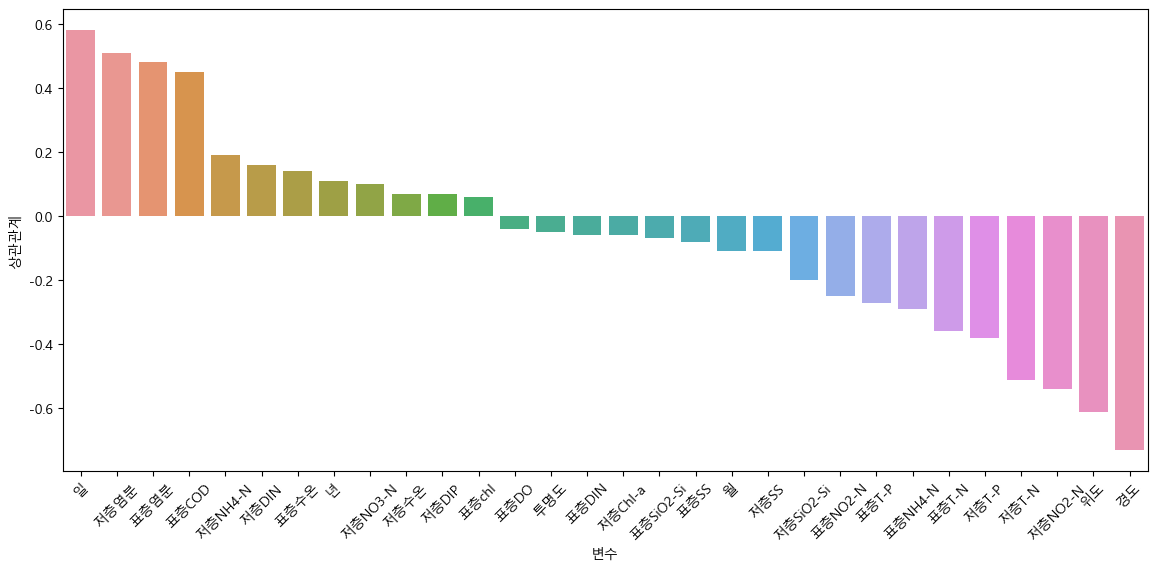

In [455]:
plt.figure(figsize=(14, 6))
sns.barplot(x='변수', y='상관관계', data=df_corr(제주_갈치))
plt.xticks(rotation=45)
plt.show()

# 모델 생성
## 생태구별 어업데이터 개체수 예측

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

def rf_model(df):
    
    X = df.drop(['개체수', '년', '월', '일', '일자'], axis=1)
    y = df.loc[:, '개체수']

    dumm_cols = list(X.select_dtypes('object').columns)

    X = pd.get_dummies(X, columns = dumm_cols, drop_first=True, dtype=int)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    x_val = scaler.transform(X_val)
    
    rf = RandomForestRegressor(n_estimators=50, max_depth=5, min_samples_split=3)
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return  y_val, y_pred, mae, rmse

In [102]:
y_val, y_pred, mae, rmse = rf_model(서남해역_어업)
print(mae)
print(rmse)

24.1550004109266
38.742978620754144


# 어종별 전체 해역 개체수
**어종별 전체 해역 개체수 시각화**

- 문어, 낙지, 돌게, 전어, 숭어, 서대, 양태, 꽃게, 새우, 장어, 소라, 고둥, 민어, 병어, 참돔, 쏨뱅이, 민꽃게, 곰장어, 부세, 꽃새우, 갈치, 갑오징어, 고등어, 참조기, 도다리, 게, 물메기, 아귀, 돔, 열기, 우럭

In [19]:
서남해역_갈치[:1]

,어업종류,어구종류이름,어종,해구도번호,조업_위도,조업_경도,개체수,년,월,일,구분,생태구,정점명,기상,수심,수질지수,표층수온,저층수온,표층염분,저층염분,표층pH,저층pH,표층DO,저층DO,표층COD,저층COD,표층NH4-N,저층NH4-N,표층NO2-N,저층NO2-N,표층NO3-N,저층NO3-N,표층DIN,저층DIN,표층T-N,저층T-N,표층DIP,저층DIP,표층T-P,저층T-P,표층SiO2-Si,저층SiO2-Si,표층SS,저층SS,표층chl,저층Chl-a,투명도,기존연안명칭,개략위치 설명,위도,경도,일자
4433,근행유자망어업,참조기유자망,갈치,193,34.135951,123.784493,124,2022,2,28,연안해역(C),서남해역,CW2307,구름조금,33.0,2.0,6.1395,5.9972,32.6024,32.5997,8.0,8.0,10.281866,10.303559,2.893104,2.813184,3.36,12.726,1.456,1.54,135.058,133.7,139.874,147.966,187.194,188.804,19.84,19.499,31.186,30.349,436.968,429.296,61.333333,60.333333,0.96,1.22,0.3,신안연안,안좌도 동방,34.719167,126.226389,2022-2-28-14:23:00


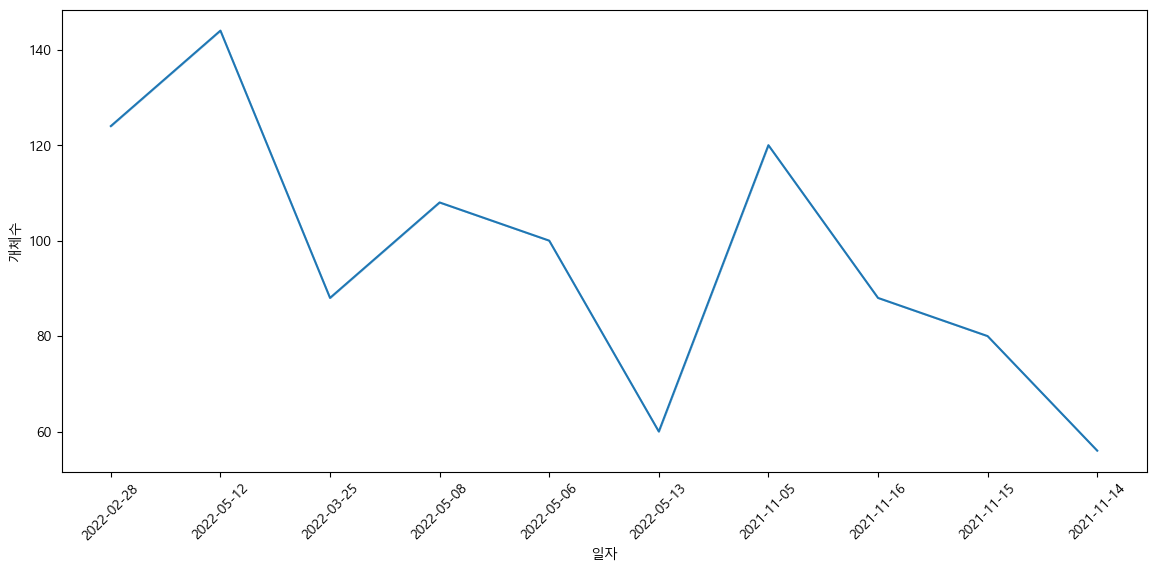

In [261]:
# 어종 별 개체수 시각화
def fish_count2(df):
    df2 = df.copy()
    df2['일자'] = pd.to_datetime(df2['일자']).dt.strftime('%Y-%m-%d')
    plt.figure(figsize=(14, 6))
    sns.lineplot(x='일자', y='개체수', data=df2)
    plt.xticks(rotation=45)
    plt.show()
    
fish_count2(서남해역_갈치)

**해역에 대한 어종별 개체수 예측 모델 - xgboost (2024년 예측불가)**

In [42]:
def fish_model(df):
    df2 = df.copy()
    df2['일자'] = pd.to_datetime(df2['일자'])
    df2['일자'] = df2['일자'].dt.strftime('%Y-%m-%d') 
    df2.groupby('일자', as_index=False)[['해구도번호', '조업_위도', '조업_경도', '개체수', '수심', '수질지수', '표층수온', '저층수온', '표층염분', '저층염분',
       '표층pH', '저층pH', '표층DO', '저층DO', '표층COD', '저층COD', '표층NH4-N', '저층NH4-N',
       '표층NO2-N', '저층NO2-N', '표층NO3-N', '저층NO3-N', '표층DIN', '저층DIN', '표층T-N',
       '저층T-N', '표층DIP', '저층DIP', '표층T-P', '저층T-P', '표층SiO2-Si', '저층SiO2-Si',
       '표층SS', '저층SS', '표층chl', '저층Chl-a', '투명도', '위도',
       '경도']].mean()
    X = df2.drop(['개체수', '일자'], axis=1)
    y = df2.loc[:, '개체수']
    y_date = df['일자']

    dumm_cols = list(X.select_dtypes('object').columns)

    X = pd.get_dummies(X, columns = dumm_cols, drop_first=True, dtype=int)
    
    X_train, X_val, y_train, y_val, y_train_date, y_val_date = train_test_split(X, y, y_date, test_size=.2, random_state=42, shuffle=True)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    x_val = scaler.transform(X_val)
    
    rf = RandomForestRegressor(n_estimators=50, max_depth=5, min_samples_split=3)
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    # df 생성
    result_df = pd.DataFrame({
        '일자': y_val_date,
        '검증_개체수': y_val,
        '예측_개체수': y_pred
    })
    result_df.sort_values('일자', ascending=True, inplace=True)

    # 평가 df 생성
    eval_df = pd.DataFrame({
        '개체수 MAE': [mae],
        '개체수 RMSE': [rmse]
    })

    return  result_df, eval_df

In [43]:
result_df, eval_df = fish_model(서남해역_갈치)
display(result_df)
display(eval_df)

,일자,검증_개체수,예측_개체수
7945,2021-11-14-10:07:00,56,104.24
11543,2021-11-14-10:07:00,56,104.24
11551,2021-11-14-10:07:00,56,104.24
11134,2021-11-14-10:07:00,56,104.24
11711,2021-11-14-10:07:00,56,104.24
...,...,...,...
9744,2022-5-8-13:51:00,108,104.24
5952,2022-5-8-13:51:00,108,104.24
9151,2022-5-8-13:51:00,108,104.24
6389,2022-5-8-13:51:00,108,104.24


,개체수 MAE,개체수 RMSE
0,20.230227,25.249524


### 2024년 8월 첫째주 예측

In [29]:
서남해역_갈치.shape

(3520, 52)

In [17]:
from prophet import Prophet
from datetime import datetime, timedelta

def fishmodel_prophet(df):
    # '일자' 날짜 형식 변환
    df['일자'] = pd.to_datetime(df['일자'], errors='coerce', format='mixed')

    # 변환 실패한 행 제거
    df = df.dropna(subset=['일자'])
    
    # df 준비
    data = df[['일자', '개체수']]
    data.rename(columns={'일자': 'ds', '개체수': 'y'}, inplace=True)
    
    # Prophet 모델 생성
    model = Prophet()
    
    # model 학습
    model.fit(data)
    
    # 다음 7일동안 24시간 예측
    future = model.make_future_dataframe(periods=24*7, freq='H')
    forecast = model.predict(future)
    
    return forecast.iloc[-(24*7):][['ds', 'yhat']][-(24*7):]

# Prophet 수질지수, 개체수, 위도, 경도 예측 df

In [25]:
from prophet import Prophet
from datetime import datetime, timedelta

def fishmodel_prophet(df):
    # '일자' 날짜 형식 변환
    df['일자'] = pd.to_datetime(df['일자'], errors='coerce', format='mixed')

    # 변환 실패한 행 제거
    df = df.dropna(subset=['일자'])

    # 예측할 변수 목록
    target_vars = ['수질지수', '개체수', '위도', '경도']

    forecasts = {}
    for target_var in target_vars:
        # df 준비
        data = df[['일자', target_var]]
        data.rename(columns={'일자': 'ds', target_var: 'y'}, inplace=True)

        # Prophet 모델 생성
        model = Prophet()

        # model 학습
        model.fit(data)

        # 다음 3개월 동안 일별 예측
        future = model.make_future_dataframe(periods=90, freq='D')
        forecast = model.predict(future)

        # 예측 결과 중에서 음수 값은 0으로 처리
        forecast['yhat'] = forecast['yhat'].clip(lower=0)

        # 수질지수 값 조정
        if target_var == '수질지수':
            forecast['yhat'] = forecast['yhat'].apply(lambda x: 1 if x < 1 else 2 if x < 2 else 3 if x < 3 else 4 if x < 4 else 5)

        # 예측 결과 저장
        forecasts[target_var] = forecast.iloc[-(90):][['ds', 'yhat']]

    # yhat 값들을 옆으로 붙여서 반환
    result = pd.concat([forecasts[target_var]['ds']] + [forecasts[target_var]['yhat'] for target_var in target_vars], axis=1)
    result.columns = ['일자', '예측_수질지수', '예측_개체수', '예측_위도', '예측_경도']
    return result

In [26]:
fishmodel_prophet(서남해역_갈치)

17:13:47 - cmdstanpy - INFO - Chain [1] start processing
17:13:48 - cmdstanpy - INFO - Chain [1] done processing
17:13:48 - cmdstanpy - INFO - Chain [1] start processing
17:13:50 - cmdstanpy - INFO - Chain [1] done processing
17:13:50 - cmdstanpy - INFO - Chain [1] start processing
17:13:52 - cmdstanpy - INFO - Chain [1] done processing
17:13:52 - cmdstanpy - INFO - Chain [1] start processing
17:13:55 - cmdstanpy - INFO - Chain [1] done processing


,일자,예측_수질지수,예측_개체수,예측_위도,예측_경도
36,2022-05-14 12:07:00,1,82.704512,34.802455,124.717306
37,2022-05-15 12:07:00,1,62.556483,34.560296,126.251976
38,2022-05-16 12:07:00,1,77.886802,35.128740,125.554295
39,2022-05-17 12:07:00,2,92.398617,34.717269,125.922273
40,2022-05-18 12:07:00,5,70.970365,36.728145,125.591604
...,...,...,...,...,...
121,2022-08-07 12:07:00,1,0.000000,37.814728,110.445548
122,2022-08-08 12:07:00,1,0.000000,38.383172,109.747866
123,2022-08-09 12:07:00,2,0.000000,37.971700,110.115844
124,2022-08-10 12:07:00,5,0.000000,39.982576,109.785176


In [112]:
# 폴더 생성
if not os.path.exists('대한해협_어종_미래7일치_예측'):
    os.makedirs('대한해협_어종_미래7일치_예측')
if not os.path.exists('서남해역_어종_미래7일치_예측'):
    os.makedirs('서남해역_어종_미래7일치_예측')
if not os.path.exists('동해_어종_미래7일치_예측'):
    os.makedirs('동해_어종_미래7일치_예측')
if not os.path.exists('서해중부_어종_미래7일치_예측'):
    os.makedirs('서해중부_어종_미래7일치_예측')
if not os.path.exists('제주_어종_미래7일치_예측'):
    os.makedirs('제주_어종_미래7일치_예측')

# 각 해역별 상관분석 결과 저장
for 대한_어종 in 대한해협_어종_리스트:
    대한해협_어종 = fishmodel_prophet(globals()[f"대한해협_{대한_어종}"])
    대한해협_어종.to_csv(os.path.join('대한해협_어종_미래7일치_예측', f"대한해협_{대한_어종}_미래7일_예측.csv"), index=False)

for 서남_어종 in 서남해역_어종_리스트:
    서남해역_어종 = fishmodel_prophet(globals()[f"서남해역_{서남_어종}"])
    서남해역_어종.to_csv(os.path.join('서남해역_어종_미래7일치_예측', f"서남해역_{서남_어종}_미래7일_예측.csv"), index=False)

for 동해_어종 in 동해_어종_리스트:
    동해해역_어종 = fishmodel_prophet(globals()[f"동해_{동해_어종}"])
    동해해역_어종.to_csv(os.path.join('동해_어종_미래7일치_예측', f"동해_{동해_어종}_미래7일_예측.csv"), index=False)

for 서해_어종 in 서해중부_어종_리스트:
    서해중부_어종 = fishmodel_prophet(globals()[f"서해중부_{서해_어종}"])
    서해중부_어종.to_csv(os.path.join('서해중부_어종_미래7일치_예측', f"서해중부_{서해_어종}_미래7일_예측.csv"), index=False)

for 제주_어종 in 제주_어종_리스트:
    제주해역_어종 = fishmodel_prophet(globals()[f"제주_{제주_어종}"])
    제주해역_어종.to_csv(os.path.join('제주_어종_미래7일치_예측', f"제주_{제주_어종}_미래7일_예측.csv"), index=False)

15:30:34 - cmdstanpy - INFO - Chain [1] start processing
15:30:37 - cmdstanpy - INFO - Chain [1] done processing
15:30:39 - cmdstanpy - INFO - Chain [1] start processing
15:30:44 - cmdstanpy - INFO - Chain [1] done processing
15:30:45 - cmdstanpy - INFO - Chain [1] start processing
15:31:03 - cmdstanpy - INFO - Chain [1] done processing
15:31:05 - cmdstanpy - INFO - Chain [1] start processing
15:31:25 - cmdstanpy - INFO - Chain [1] done processing
15:31:26 - cmdstanpy - INFO - Chain [1] start processing
15:31:27 - cmdstanpy - INFO - Chain [1] done processing
15:31:27 - cmdstanpy - INFO - Chain [1] start processing
15:31:28 - cmdstanpy - INFO - Chain [1] done processing
15:31:29 - cmdstanpy - INFO - Chain [1] start processing
15:31:33 - cmdstanpy - INFO - Chain [1] done processing
15:31:33 - cmdstanpy - INFO - Chain [1] start processing
15:31:38 - cmdstanpy - INFO - Chain [1] done processing
15:31:39 - cmdstanpy - INFO - Chain [1] start processing
15:31:39 - cmdstanpy - INFO - Chain [1]

In [119]:
import os
import pandas as pd

# 대한해협
대한해협_파일리스트 = os.listdir('대한해협_어종_미래7일치_예측')
대한해협_df = pd.concat([pd.read_csv(os.path.join('대한해협_어종_미래7일치_예측', 파일)).assign(해역='대한해협', 어종=파일.split('_')[1]) for 파일 in 대한해협_파일리스트])
대한해협_df.to_csv('대한해협_어종_미래7일치_예측.csv', index=False)

# 서남해역
서남해역_파일리스트 = os.listdir('서남해역_어종_미래7일치_예측')
서남해역_df = pd.concat([pd.read_csv(os.path.join('서남해역_어종_미래7일치_예측', 파일)).assign(해역='서남해역', 어종=파일.split('_')[1]) for 파일 in 서남해역_파일리스트])
서남해역_df.to_csv('서남해역_어종_미래7일치_예측.csv', index=False)

# 동해
동해_파일리스트 = os.listdir('동해_어종_미래7일치_예측')
동해_df = pd.concat([pd.read_csv(os.path.join('동해_어종_미래7일치_예측', 파일)).assign(해역='동해', 어종=파일.split('_')[1]) for 파일 in 동해_파일리스트])
동해_df.to_csv('동해_어종_미래7일치_예측.csv', index=False)

# 서해중부
서해중부_파일리스트 = os.listdir('서해중부_어종_미래7일치_예측')
서해중부_df = pd.concat([pd.read_csv(os.path.join('서해중부_어종_미래7일치_예측', 파일)).assign(해역='서해중부', 어종=파일.split('_')[1]) for 파일 in 서해중부_파일리스트])
서해중부_df.to_csv('서해중부_어종_미래7일치_예측.csv', index=False)

# 제주
제주_파일리스트 = os.listdir('제주_어종_미래7일치_예측')
제주_df = pd.concat([pd.read_csv(os.path.join('제주_어종_미래7일치_예측', 파일)).assign(해역='제주', 어종=파일.split('_')[1]) for 파일 in 제주_파일리스트])
제주_df.to_csv('제주_어종_미래7일치_예측.csv', index=False)

# 시계열 분석 df 함수 - globals로 저장하면 편함 

In [17]:
import statsmodels.api as sm

# 시계열 분석 함수 - 일주일 단위
def decomp_plot(df):
    result = pd.DataFrame()
    for col in ['수질지수', '개체수', '위도', '경도']:
        temp = df.loc[df['일자'].between('2011-11-01', '2022-08-31')]
        
        if len(temp) < 60:
            print(f"{col}에 대한 데이터가 충분하지 않습니다. (관측값 {len(temp)}개)")
            continue
        
        # 시계열 데이터 분해
        decomp = sm.tsa.seasonal_decompose(temp[col], model='additive', period=30)
        
        # 시계열 분해 결과를 받아서 df로 저장
        observed = decomp.observed.fillna(decomp.observed.mean())
        trend = decomp.trend.fillna(decomp.trend.mean())
        seasonal = decomp.seasonal.fillna(decomp.seasonal.mean())
        resid = decomp.resid.fillna(decomp.resid.mean())
        
        result[f"{col}_관측값"] = observed
        result[f"{col}_추세"] = trend
        result[f"{col}_계절"] = seasonal
        result[f"{col}_잔차"] = resid
    
    return result

In [19]:
decomp_plot(제주_갈치)

,수질지수_관측값,수질지수_추세,수질지수_계절,수질지수_잔차,개체수_관측값,개체수_추세,개체수_계절,개체수_잔차,위도_관측값,위도_추세,위도_계절,위도_잔차,경도_관측값,경도_추세,경도_계절,경도_잔차
7546,2.0,1.106906,0.073364,-0.000031,60.0,87.346614,-0.17554,-0.00046,33.280833,33.352764,0.002607,0.000033,126.767500,126.486131,0.026989,-0.000056
7547,1.0,1.106906,-0.026969,-0.000031,60.0,87.346614,-0.17554,-0.00046,33.325556,33.352764,0.019719,0.000033,126.865556,126.486131,-0.015176,-0.000056
7548,1.0,1.106906,-0.067302,-0.000031,60.0,87.346614,0.70446,-0.00046,33.411389,33.352764,0.017276,0.000033,126.938611,126.486131,-0.031065,-0.000056
7549,1.0,1.106906,-0.007302,-0.000031,60.0,87.346614,0.70446,-0.00046,33.480000,33.352764,0.000134,0.000033,126.938611,126.486131,-0.028210,-0.000056
7550,1.0,1.106906,0.072698,-0.000031,60.0,87.346614,0.70446,-0.00046,33.537500,33.352764,0.000063,0.000033,126.855556,126.486131,-0.032660,-0.000056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11833,1.0,1.106906,-0.026969,-0.000031,60.0,87.346614,-0.17554,-0.00046,33.573889,33.352764,0.019719,0.000033,126.732778,126.486131,-0.015176,-0.000056
11834,1.0,1.106906,-0.067302,-0.000031,60.0,87.346614,0.70446,-0.00046,33.560556,33.352764,0.017276,0.000033,126.666389,126.486131,-0.031065,-0.000056
11835,1.0,1.106906,-0.007302,-0.000031,60.0,87.346614,0.70446,-0.00046,33.533889,33.352764,0.000134,0.000033,126.568333,126.486131,-0.028210,-0.000056
11836,1.0,1.106906,0.072698,-0.000031,60.0,87.346614,0.70446,-0.00046,33.526944,33.352764,0.000063,0.000033,126.532778,126.486131,-0.032660,-0.000056


In [51]:
# 폴더 생성
folders = ['대한해협_어종_시계열분석', '서남해역_어종_시계열분석', '동해_어종_시계열분석', '서해중부_어종_시계열분석', '제주_어종_시계열분석']
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)


# 각 해역별 어종 시계열 분석 결과 저장
for 대한_어종 in 대한해협_어종_리스트:
    df_name = f"대한해협_{대한_어종}"
    if df_name in globals():
        대한해협_어종 = decomp_plot(globals()[df_name])
        대한해협_어종.to_csv(os.path.join('대한해협_어종_시계열분석', f"대한해협_{대한_어종}_시계열분석.csv"), index=False)

for 서남_어종 in 서남해역_어종_리스트:
    df_name = f"서남해역_{서남_어종}"
    if df_name in globals():
        서남해역_어종 = decomp_plot(globals()[df_name])
        서남해역_어종.to_csv(os.path.join('서남해역_어종_시계열분석', f"서남해역_{서남_어종}_시계열분석.csv"), index=False)

for 동해_어종 in 동해_어종_리스트:
    df_name = f"동해_{동해_어종}"
    if df_name in globals():
        동해해역_어종 = decomp_plot(globals()[df_name])
        동해해역_어종.to_csv(os.path.join('동해_어종_시계열분석', f"동해_{동해_어종}_시계열분석.csv"), index=False)

for 서해_어종 in 서해중부_어종_리스트:
    df_name = f"서해중부_{서해_어종}"
    if df_name in globals():
        서해중부_어종 = decomp_plot(globals()[df_name])
        서해중부_어종.to_csv(os.path.join('서해중부_어종_시계열분석', f"서해중부_{서해_어종}_시계열분석.csv"), index=False)

for 제주_어종 in 제주_어종_리스트:
    df_name = f"제주_{제주_어종}"
    if df_name in globals():
        제주해역_어종 = decomp_plot(globals()[df_name])
        제주해역_어종.to_csv(os.path.join('제주_어종_시계열분석', f"제주_{제주_어종}_시계열분석.csv"), index=False)

수질지수에 대한 데이터가 충분하지 않습니다. (관측값 0개)
개체수에 대한 데이터가 충분하지 않습니다. (관측값 0개)
위도에 대한 데이터가 충분하지 않습니다. (관측값 0개)
경도에 대한 데이터가 충분하지 않습니다. (관측값 0개)
수질지수에 대한 데이터가 충분하지 않습니다. (관측값 0개)
개체수에 대한 데이터가 충분하지 않습니다. (관측값 0개)
위도에 대한 데이터가 충분하지 않습니다. (관측값 0개)
경도에 대한 데이터가 충분하지 않습니다. (관측값 0개)
수질지수에 대한 데이터가 충분하지 않습니다. (관측값 0개)
개체수에 대한 데이터가 충분하지 않습니다. (관측값 0개)
위도에 대한 데이터가 충분하지 않습니다. (관측값 0개)
경도에 대한 데이터가 충분하지 않습니다. (관측값 0개)
수질지수에 대한 데이터가 충분하지 않습니다. (관측값 20개)
개체수에 대한 데이터가 충분하지 않습니다. (관측값 20개)
위도에 대한 데이터가 충분하지 않습니다. (관측값 20개)
경도에 대한 데이터가 충분하지 않습니다. (관측값 20개)
수질지수에 대한 데이터가 충분하지 않습니다. (관측값 34개)
개체수에 대한 데이터가 충분하지 않습니다. (관측값 34개)
위도에 대한 데이터가 충분하지 않습니다. (관측값 34개)
경도에 대한 데이터가 충분하지 않습니다. (관측값 34개)
수질지수에 대한 데이터가 충분하지 않습니다. (관측값 37개)
개체수에 대한 데이터가 충분하지 않습니다. (관측값 37개)
위도에 대한 데이터가 충분하지 않습니다. (관측값 37개)
경도에 대한 데이터가 충분하지 않습니다. (관측값 37개)
수질지수에 대한 데이터가 충분하지 않습니다. (관측값 27개)
개체수에 대한 데이터가 충분하지 않습니다. (관측값 27개)
위도에 대한 데이터가 충분하지 않습니다. (관측값 27개)
경도에 대한 데이터가 충분하지 않습니다. (관측값 27개)
수질지수에 대한 데이터가 충분하지 않습니다. (관측값 44개)
개체수에 대한 데이터가 충분하지 않습니다. (관측값 44개

In [53]:
import os
def read_and_assign(file_path, 해역, 어종):
    try:
        df = pd.read_csv(file_path)
        if df.empty:
            print(f"{file_path}은 비어 있습니다.")
            return None
        return df.assign(해역=해역, 어종=어종)
    except pd.errors.EmptyDataError:
        print(f"{file_path}에서 열을 찾을 수 없습니다.")
        return None

# 대한해협
대한해협_파일리스트 = os.listdir('대한해협_어종_시계열분석')
대한해협_df_list = [read_and_assign(os.path.join('대한해협_어종_시계열분석', 파일), '대한해협', 파일.split('_')[1]) for 파일 in 대한해협_파일리스트]
대한해협_df_list = [df for df in 대한해협_df_list if df is not None]
if 대한해협_df_list:
    대한해협_df = pd.concat(대한해협_df_list)
    대한해협_df.to_csv('대한해협_어종_시계열분석.csv', index=False)

# 서남해역
서남해역_파일리스트 = os.listdir('서남해역_어종_시계열분석')
서남해역_df_list = [read_and_assign(os.path.join('서남해역_어종_시계열분석', 파일), '서남해역', 파일.split('_')[1]) for 파일 in 서남해역_파일리스트]
서남해역_df_list = [df for df in 서남해역_df_list if df is not None]
if 서남해역_df_list:
    서남해역_df = pd.concat(서남해역_df_list)
    서남해역_df.to_csv('서남해역_어종_시계열분석.csv', index=False)

# 동해
동해_파일리스트 = os.listdir('동해_어종_시계열분석')
동해_df_list = [read_and_assign(os.path.join('동해_어종_시계열분석', 파일), '동해', 파일.split('_')[1]) for 파일 in 동해_파일리스트]
동해_df_list = [df for df in 동해_df_list if df is not None]
if 동해_df_list:
    동해_df = pd.concat(동해_df_list)
    동해_df.to_csv('동해_어종_시계열분석.csv', index=False)

# 서해중부
서해중부_파일리스트 = os.listdir('서해중부_어종_시계열분석')
서해중부_df_list = [read_and_assign(os.path.join('서해중부_어종_시계열분석', 파일), '서해중부', 파일.split('_')[1]) for 파일 in 서해중부_파일리스트]
서해중부_df_list = [df for df in 서해중부_df_list if df is not None]
if 서해중부_df_list:
    서해중부_df = pd.concat(서해중부_df_list)
    서해중부_df.to_csv('서해중부_어종_시계열분석.csv', index=False)

# 제주
제주_파일리스트 = os.listdir('제주_어종_시계열분석')
제주_df_list = [read_and_assign(os.path.join('제주_어종_시계열분석', 파일), '제주', 파일.split('_')[1]) for 파일 in 제주_파일리스트]
제주_df_list = [df for df in 제주_df_list if df is not None]
if 제주_df_list:
    제주_df = pd.concat(제주_df_list)
    제주_df.to_csv('제주_어종_시계열분석.csv', index=False)

대한해협_어종_시계열분석\대한해협_갑오징어_시계열분석.csv에서 열을 찾을 수 없습니다.
대한해협_어종_시계열분석\대한해협_고등어_시계열분석.csv에서 열을 찾을 수 없습니다.
대한해협_어종_시계열분석\대한해협_도다리_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_갑오징어_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_게_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_고둥_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_고등어_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_곰장어_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_꽃새우_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_도다리_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_돔_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_물메기_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_부세_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_소라_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_쏨뱅이_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_열기_시계열분석.csv에서 열을 찾을 수 없습니다.
서남해역_어종_시계열분석\서남해역_우럭_시계열분석.csv에서 열을 찾을 수 없습니다.
동해_어종_시계열분석\동해_게_시계열분석.csv에서 열을 찾을 수 없습니다.
동해_어종_시계열분석\동해_곰장어_시계열분석.csv에서 열을 찾을 수 없습니다.
동해_어종_시계열분석\동해_물메기_시계열분석.csv에서 열을 찾을 수 없습니다.
동해_어종_시계열분석\동해_부세_시계열분석.csv에서 열을 찾을 수 없습니

In [20]:
제주_갈치[:1]

,어업종류,어구종류이름,어종,해구도번호,조업_위도,조업_경도,개체수,년,월,일,구분,생태구,정점명,기상,수심,수질지수,표층수온,저층수온,표층염분,저층염분,표층pH,저층pH,표층DO,저층DO,표층COD,저층COD,표층NH4-N,저층NH4-N,표층NO2-N,저층NO2-N,표층NO3-N,저층NO3-N,표층DIN,저층DIN,표층T-N,저층T-N,표층DIP,저층DIP,표층T-P,저층T-P,표층SiO2-Si,저층SiO2-Si,표층SS,저층SS,표층chl,저층Chl-a,투명도,기존연안명칭,개략위치 설명,위도,경도,일자
5653,근해유자망어업,참조기유자망,갈치,202,34.050632,123.693476,100,2022,5,18,연안해역(C),제주,CJ2602,맑음,22.0,2.0,17.4595,16.9762,34.1467,34.1944,8.0,8.0,8.525767,7.670358,0.95,2.39,2.954,5.67,1.288,1.162,15.988,21.602,20.23,28.434,115.108,120.736,0.403,1.705,15.19,12.462,195.664,159.404,3.65,4.75,1.96,2.24,7.0,제주연안,이호해수욕장 서측,33.500556,126.427778,2022-5-18-09:20:00


# ANOVA 분석 - 수질지수에 따른 개체수, 표층수온, 저층수온, 표층염분, 저층염분, 위도, 경도 

In [30]:
# 분산분석 함수
def anova_ocean(df):
    df['수질지수'] = df['수질지수'].astype('int')
    temp = df.loc[df['개체수'].notnull()]
    # 그룹별
    c_1 = temp.loc[temp.수질지수 == 1, '개체수']
    c_2 = temp.loc[temp.수질지수 == 2, '개체수']
    c_3 = temp.loc[temp.수질지수 == 3, '개체수']
    c_4 = temp.loc[temp.수질지수 == 4, '개체수']
    c_5 = temp.loc[temp.수질지수 == 5, '개체수']


    anova_c = spst.f_oneway(c_1, c_2, c_3, c_4, c_5)
    return anova_c

In [35]:
import scipy.stats as spst

def anova_ocean(df):
    df['수질지수'] = df['수질지수'].astype('int')
    # 각 열에 대해 결측치가 아닌 행을 필터링
    temp = df.dropna(subset=['개체수', '표층수온', '저층수온', '표층염분', '저층염분', '위도', '경도'])
    
    # 그룹별로 데이터 추출
    groups = {i: temp.loc[temp.수질지수 == i] for i in range(1, 6)}
    
    c = [group['개체수'] for group in groups.values()]
    p = [group['표층수온'] for group in groups.values()]
    l = [group['저층수온'] for group in groups.values()]
    py = [group['표층염분'] for group in groups.values()]
    ly = [group['저층염분'] for group in groups.values()]
    x = [group['위도'] for group in groups.values()]
    y = [group['경도'] for group in groups.values()]

    # ANOVA 
    anova_results = {
        '개체수': spst.f_oneway(*c),
        '표층수온': spst.f_oneway(*p),
        '저층수온': spst.f_oneway(*l),
        '표층염분': spst.f_oneway(*py),
        '저층염분': spst.f_oneway(*ly),
        '위도': spst.f_oneway(*x),
        '경도': spst.f_oneway(*y)
    }

    # 결과를 데이터프레임에 정리
    anova_df = pd.DataFrame({
        '변수명': list(anova_results.keys()),
        '검정통계량': [result.statistic for result in anova_results.values()],
        'p-value': [result.pvalue for result in anova_results.values()]
    })
    return anova_df

In [36]:
anova_ocean(동해_갈치)

,변수명,검정통계량,p-value
0,개체수,118.938720,1.406429e-96
1,표층수온,19.719109,4.173875e-16
2,저층수온,249.761812,5.798872e-194
3,표층염분,359.496669,8.066514e-269
4,저층염분,435.746734,1.180192e-317
5,위도,704.472936,0.000000e+00
6,경도,442.839113,4.495997e-322


In [37]:
# 폴더 생성
folders = ['대한해협_어종_anova', '서남해역_어종_anova', '동해_어종_anova', '서해중부_어종_anova', '제주_어종_anova']
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)


# 각 해역별 어종 분산분석 결과 저장
for 대한_어종 in 대한해협_어종_리스트:
    대한해협_어종 = anova_ocean(globals()[f"대한해협_{대한_어종}"])
    대한해협_어종.to_csv(os.path.join('대한해협_어종_anova', f"대한해협_{대한_어종}_분산분석.csv"), index=False)

for 서남_어종 in 서남해역_어종_리스트:
    서남해역_어종 = anova_ocean(globals()[f"서남해역_{서남_어종}"])
    서남해역_어종.to_csv(os.path.join('서남해역_어종_anova', f"서남해역_{서남_어종}_분산분석.csv"), index=False)

for 동해_어종 in 동해_어종_리스트:
    동해해역_어종 = anova_ocean(globals()[f"동해_{동해_어종}"])
    동해해역_어종.to_csv(os.path.join('동해_어종_anova', f"동해_{동해_어종}_분산분석.csv"), index=False)

for 서해_어종 in 서해중부_어종_리스트:
    서해중부_어종 = anova_ocean(globals()[f"서해중부_{서해_어종}"])
    서해중부_어종.to_csv(os.path.join('서해중부_어종_anova', f"서해중부_{서해_어종}_분산분석.csv"), index=False)

for 제주_어종 in 제주_어종_리스트:
    제주해역_어종 = anova_ocean(globals()[f"제주_{제주_어종}"])
    제주해역_어종.to_csv(os.path.join('제주_어종_anova', f"제주_{제주_어종}_분산분석.csv"), index=False)

In [38]:
import os
import pandas as pd

# 대한해협
대한해협_파일리스트 = os.listdir('대한해협_어종_anova')
대한해협_df = pd.concat([pd.read_csv(os.path.join('대한해협_어종_anova', 파일)).assign(해역='대한해협', 어종=파일.split('_')[1]) for 파일 in 대한해협_파일리스트])
대한해협_df.to_csv('대한해협_어종_anova.csv', index=False)

# 서남해역
서남해역_파일리스트 = os.listdir('서남해역_어종_anova')
서남해역_df = pd.concat([pd.read_csv(os.path.join('서남해역_어종_anova', 파일)).assign(해역='서남해역', 어종=파일.split('_')[1]) for 파일 in 서남해역_파일리스트])
서남해역_df.to_csv('서남해역_어종_anova.csv', index=False)

# 동해
동해_파일리스트 = os.listdir('동해_어종_anova')
동해_df = pd.concat([pd.read_csv(os.path.join('동해_어종_anova', 파일)).assign(해역='동해', 어종=파일.split('_')[1]) for 파일 in 동해_파일리스트])
동해_df.to_csv('동해_어종_anova.csv', index=False)

# 서해중부
서해중부_파일리스트 = os.listdir('서해중부_어종_anova')
서해중부_df = pd.concat([pd.read_csv(os.path.join('서해중부_어종_anova', 파일)).assign(해역='서해중부', 어종=파일.split('_')[1]) for 파일 in 서해중부_파일리스트])
서해중부_df.to_csv('서해중부_어종_anova.csv', index=False)

# 제주
제주_파일리스트 = os.listdir('제주_어종_anova')
제주_df = pd.concat([pd.read_csv(os.path.join('제주_어종_anova', 파일)).assign(해역='제주', 어종=파일.split('_')[1]) for 파일 in 제주_파일리스트])
제주_df.to_csv('제주_어종_anova.csv', index=False)

In [62]:
a = pd.read_csv('대한해협_어종_anova.csv')
b = pd.read_csv('서남해역_어종_anova.csv')
c = pd.read_csv('동해_어종_anova.csv')
d = pd.read_csv('서해중부_어종_anova.csv')
e = pd.read_csv('제주_어종_anova.csv')
anova_ocean = pd.concat([a, b, c, d, e], axis=0)
anova_ocean.dropna(axis=0, inplace=True)
anova_ocean.head()

,변수명,검정통계량,p-value,해역,어종
0,개체수,545.683610,0.0,대한해협,갈치
1,표층수온,765.375619,0.0,대한해협,갈치
2,저층수온,812.540362,0.0,대한해협,갈치
3,표층염분,1482.979653,0.0,대한해협,갈치
4,저층염분,1068.584556,0.0,대한해협,갈치


In [63]:
anova_ocean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 0 to 202
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   변수명      462 non-null    object 
 1   검정통계량    462 non-null    float64
 2   p-value  462 non-null    float64
 3   해역       462 non-null    object 
 4   어종       462 non-null    object 
dtypes: float64(2), object(3)
memory usage: 21.7+ KB


In [66]:
anova_ocean['해역'].value_counts()

해역
대한해협    207
동해      158
서해중부     97
Name: count, dtype: int64

In [67]:
# 전체해역 어종 anova 분석 csv 저장
anova_ocean.to_csv('전체해역 어종 ANOVA 분석.csv', index=False)

# 해양생물의 최적 군집 위치

In [110]:
def kmeans_xy(df):
    # 위도와 경도 값 추출
    lat = df['위도'].tolist()
    lon = df['경도'].tolist()

    # K-means 클러스터링
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(np.column_stack((lat, lon)))
    labels = kmeans.labels_

    # 군집 중심점 좌표 확인
    cluster_centers = kmeans.cluster_centers_

    # df 반환
    optimal_lat, optimal_lon = cluster_centers[:, 0], cluster_centers[:, 1]
    return pd.DataFrame({'최적위도': optimal_lat, '최적경도': optimal_lon})

In [111]:
# 폴더 생성
if not os.path.exists('대한해협_어종_군집좌표'):
    os.makedirs('대한해협_어종_군집좌표')
if not os.path.exists('서남해역_어종_군집좌표'):
    os.makedirs('서남해역_어종_군집좌표')
if not os.path.exists('동해_어종_군집좌표'):
    os.makedirs('동해_어종_군집좌표')
if not os.path.exists('서해중부_어종_군집좌표'):
    os.makedirs('서해중부_어종_군집좌표')
if not os.path.exists('제주_어종_군집좌표'):
    os.makedirs('제주_어종_군집좌표')

# 각 해역별 어종 군집좌표 저장
for 대한_어종 in 대한해협_어종_리스트:
    대한해협_어종 = kmeans_xy(globals()[f"대한해협_{대한_어종}"])
    대한해협_어종.to_csv(os.path.join('대한해협_어종_군집좌표', f"대한해협_{대한_어종}_군집좌표.csv"), index=False)

for 서남_어종 in 서남해역_어종_리스트:
    서남해역_어종 = kmeans_xy(globals()[f"서남해역_{서남_어종}"])
    서남해역_어종.to_csv(os.path.join('서남해역_어종_군집좌표', f"서남해역_{서남_어종}_군집좌표.csv"), index=False)

for 동해_어종 in 동해_어종_리스트:
    동해해역_어종 = kmeans_xy(globals()[f"동해_{동해_어종}"])
    동해해역_어종.to_csv(os.path.join('동해_어종_군집좌표', f"동해_{동해_어종}_군집좌표.csv"), index=False)

for 서해_어종 in 서해중부_어종_리스트:
    서해중부_어종 = kmeans_xy(globals()[f"서해중부_{서해_어종}"])
    서해중부_어종.to_csv(os.path.join('서해중부_어종_군집좌표', f"서해중부_{서해_어종}_군집좌표.csv"), index=False)

for 제주_어종 in 제주_어종_리스트:
    제주해역_어종 = kmeans_xy(globals()[f"제주_{제주_어종}"])
    제주해역_어종.to_csv(os.path.join('제주_어종_군집좌표', f"제주_{제주_어종}_군집좌표.csv"), index=False)

# 해양환경 ↔ 해양생물 서식지 중요도 분석

In [449]:
def fish_model2(df):
    df2 = df.copy()
    df2['일자'] = pd.to_datetime(df2['일자'])
    df2['일자'] = df2['일자'].dt.strftime('%Y-%m-%d') 
    df2.groupby('일자', as_index=False)[['해구도번호', '조업_위도', '조업_경도', '개체수', '수심', '수질지수', '표층수온', '저층수온', '표층염분', '저층염분',
       '표층pH', '저층pH', '표층DO', '저층DO', '표층COD', '저층COD', '표층NH4-N', '저층NH4-N',
       '표층NO2-N', '저층NO2-N', '표층NO3-N', '저층NO3-N', '표층DIN', '저층DIN', '표층T-N',
       '저층T-N', '표층DIP', '저층DIP', '표층T-P', '저층T-P', '표층SiO2-Si', '저층SiO2-Si',
       '표층SS', '저층SS', '표층chl', '저층Chl-a', '투명도', '위도',
       '경도']].mean()
    X = df2.drop(['개체수', '일자'], axis=1)
    y = df2.loc[:, '개체수']
    y_date = df['일자']

    dumm_cols = list(X.select_dtypes('object').columns)

    X = pd.get_dummies(X, columns = dumm_cols, drop_first=True, dtype=int)
    
    X_train, X_val, y_train, y_val, y_train_date, y_val_date = train_test_split(X, y, y_date, test_size=.2, random_state=42, shuffle=True)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    x_val = scaler.transform(X_val)
    
    rf = RandomForestRegressor(n_estimators=50, max_depth=5, min_samples_split=3)
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    # df 생성
    result_df = pd.DataFrame({
        '일자': y_val_date,
        '검증_개체수': y_val,
        '예측_개체수': y_pred
    })
    result_df.sort_values('일자', ascending=True, inplace=True)

    # 평가 df 생성
    eval_df = pd.DataFrame({
        '개체수 MAE': [mae],
        '개체수 RMSE': [rmse]
    })
    
    # Feature 중요도 확인
    fig, ax = plt.subplots(figsize=(12, 12))
    importance = rf.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]  # 내림차순 정렬
    top_10_features = np.array(list(X))[sorted_idx[:10]]  # 상위 10개 
    top_10_importances = importance[sorted_idx[:10]]  # 상위 10개 중요도
    
    ax.barh(y=top_10_features, width=top_10_importances, color='blue')
    ax.set_title('변수중요도 분석')
    ax.set_xlabel('중요도')
    ax.set_ylabel('변수')
    ax.invert_yaxis()  # y축 방향 반전
    fig.tight_layout()
    plt.show()
    
    return  result_df, eval_df

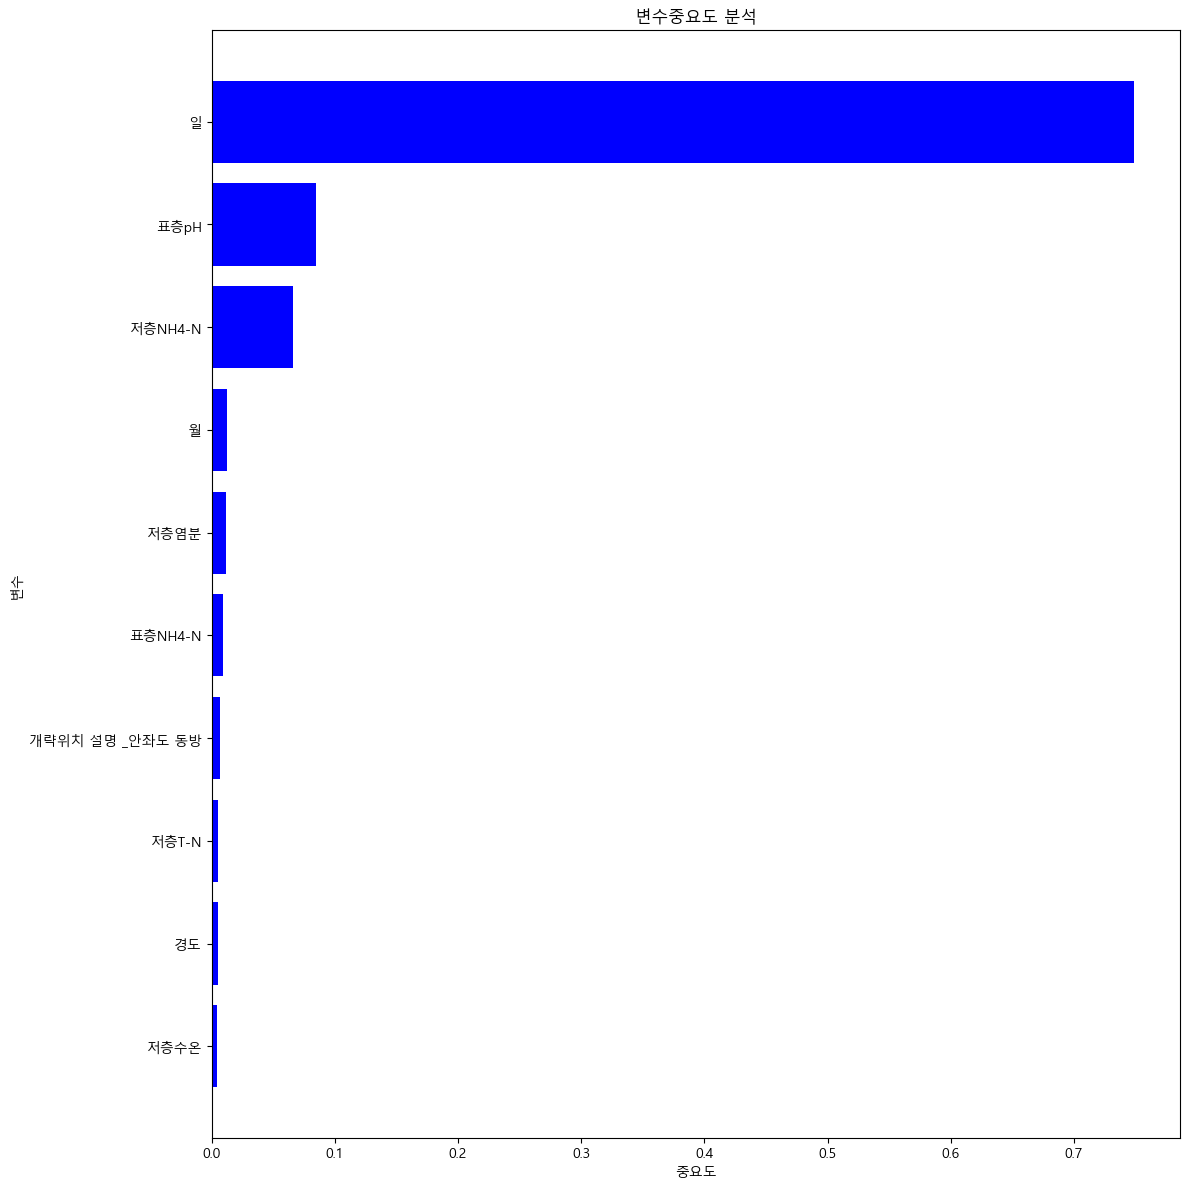

,일자,검증_개체수,예측_개체수
54018,2021-11-05 11:32:00,120,100.00
39914,2021-11-05 11:32:00,120,100.00
60652,2021-11-05 11:32:00,120,100.00
56798,2021-11-05 11:32:00,120,100.00
53133,2021-11-05 11:32:00,120,100.00
...,...,...,...
37340,2022-05-13 12:07:00,60,105.68
37344,2022-05-13 12:07:00,60,105.68
37348,2022-05-13 12:07:00,60,105.68
35015,2022-05-13 12:07:00,60,105.68


,개체수 MAE,개체수 RMSE
0,19.71625,25.53377


In [450]:
result_df, eval_df = fish_model2(서남해역_갈치)
display(result_df)
display(eval_df)


# 어종별 분포위치 변화
**어종별 분포 위치 시각화**

In [463]:
def fish_map(df):
    # 일자별 개체수 계산
    df['일자'] = pd.to_datetime(df['일자'])
    df_grouped = df.groupby(['일자', '위도', '경도'])['개체수'].sum().reset_index()
    
    # 지도 생성
    m = folium.Map(location=[df['위도'].mean(), df['경도'].mean()], zoom_start=8)
    
    # 일자별 개체수 표시
    for i, row in df_grouped.iterrows():
        folium.Marker(
            location=[row['위도'], row['경도']],
            popup=f"Date: {row['일자'].strftime('%Y-%m-%d %H:%M:%S')}<br>개체수: {row['개체수']}",
            icon=folium.Icon(color='red', icon='circle', prefix='fa')
        ).add_to(m)
    
    # 지도 표시
    return m

In [464]:
m = fish_map2(서남해역_갈치)
m

In [465]:
temp = 서남해역_갈치.copy()
temp['위치'] = temp['위도'].astype(str) + ', ' + temp['경도'].astype(str)
temp = temp.groupby(by='위치', as_index=False).value_counts()
boat = drawing_heatmap(temp, '개체수', 10)
boat

**어종별 분포 위치 예측 모델**

In [466]:
def fish_lat_lon_model(df):
    
    X = df.drop(['년', '월', '일', '일자', '위도', '경도', '개체수'], axis=1)
    y_lat = df['위도']
    y_lon = df['경도']
    y_date = df['일자']
    
    dumm_cols = list(X.select_dtypes('object').columns)
    X = pd.get_dummies(X, columns = dumm_cols, drop_first=True, dtype=int)
    
    X_train, X_val, y_train_lat, y_val_lat, y_train_lon, y_val_lon, y_train_date, y_val_date = train_test_split(X, y_lat, y_lon, y_date, 
                                                                                                                test_size=0.2, random_state=42)

    
    rf_lat = RandomForestRegressor(n_estimators=50, max_depth=5)
    
    rf_lat.fit(X_train, y_train_lat)
    y_pred_lat = rf_lat.predict(X_val)
    
    rf_lon = RandomForestRegressor(n_estimators=50, max_depth=10)
    
    rf_lon.fit(X_train, y_train_lon)
    y_pred_lon = rf_lon.predict(X_val)

    mae_lat = mean_absolute_error(y_val_lat, y_pred_lat)
    mae_lon = mean_absolute_error(y_val_lon, y_pred_lon)
    rmse_lat = mean_squared_error(y_val_lat, y_pred_lat, squared=False)
    rmse_lon = mean_squared_error(y_val_lon, y_pred_lon, squared=False)

    # df 생성
    result_df = pd.DataFrame({
        '일자': y_val_date,
        '검증_위도': y_val_lat,
        '검증_경도': y_val_lon,
        '예측_위도': y_pred_lat,
        '예측_경도': y_pred_lon
    })
    result_df.sort_values('일자', ascending=True, inplace=True)

    # 평가 df 생성
    eval_df = pd.DataFrame({
        '위도 MAE': [mae_lat],
        '경도 MAE': [mae_lon],
        '위도 RMSE': [rmse_lat],
        '경도 RMSE': [rmse_lon]
    })
    
    return  result_df, eval_df

In [17]:
from xgboost import XGBRegressor
def fish_xy_count_model(df):
    
    X = df.drop(['년', '월', '일', '일자', '위도', '경도', '개체수'], axis=1)
    y_lat = df['위도']
    y_lon = df['경도']
    y_date = df['일자']
    y_count = df['개체수']
    
    dumm_cols = list(X.select_dtypes('object').columns)
    X = pd.get_dummies(X, columns = dumm_cols, drop_first=True, dtype=int)
    
    X_train, X_val, y_train_lat, y_val_lat, y_train_lon, y_val_lon, y_train_date, y_val_date, y_train_count, y_val_count = train_test_split(X, y_lat, 
                                                                               y_lon, y_date, y_count, test_size=0.2, random_state=42)

    
    rf_lat = RandomForestRegressor(n_estimators=50, max_depth=5)
    
    rf_lat.fit(X_train, y_train_lat)
    y_pred_lat = rf_lat.predict(X_val)
    
    rf_lon = RandomForestRegressor(n_estimators=50, max_depth=5)
    
    rf_lon.fit(X_train, y_train_lon)
    y_pred_lon = rf_lon.predict(X_val)

    xgb_count = XGBRegressor(n_estimators=50, max_depth=5)
    xgb_count.fit(X_train, y_train_count)
    y_pred_count = xgb_count.predict(X_val)

    mae_lat = mean_absolute_error(y_val_lat, y_pred_lat)
    mae_lon = mean_absolute_error(y_val_lon, y_pred_lon)
    rmse_lat = mean_squared_error(y_val_lat, y_pred_lat, squared=False)
    rmse_lon = mean_squared_error(y_val_lon, y_pred_lon, squared=False)
    mae_count = mean_absolute_error(y_val_count, y_pred_count)
    rmse_count = mean_squared_error(y_val_count, y_pred_count, squared=False)

    # df 생성
    result_df = pd.DataFrame({
        '일자': y_val_date,
        '검증_위도': y_val_lat,
        '검증_경도': y_val_lon,
        '예측_위도': y_pred_lat,
        '예측_경도': y_pred_lon,
        '검증_개체수': y_val_count,
        '예측_개체수': y_pred_count
    })
    result_df.sort_values('일자', ascending=True, inplace=True)

    # 평가 df 생성
    eval_df = pd.DataFrame({
        '위도 MAE': [mae_lat],
        '경도 MAE': [mae_lon],
        '위도 RMSE': [rmse_lat],
        '경도 RMSE': [rmse_lon],
        '개체수 MAE': [mae_count],
        '개체수 RMSE': [rmse_count]
    })
    
    return  result_df, eval_df

In [490]:
result_df, eval_df = fish_lat_lon_model(서남해역_갈치)
display(result_df)
display(eval_df)

,일자,검증_위도,검증_경도,예측_위도,예측_경도
54018,2021-11-05 11:32:00,34.595833,126.226389,34.595833,126.226389
39914,2021-11-05 11:32:00,34.595833,126.226389,34.595833,126.226389
60652,2021-11-05 11:32:00,34.595833,126.226389,34.595833,126.226389
56798,2021-11-05 11:32:00,34.595833,126.226389,34.595833,126.226389
53133,2021-11-05 11:32:00,34.595833,126.226389,34.595833,126.226389
...,...,...,...,...,...
37340,2022-05-13 12:07:00,34.595833,126.226389,34.595833,126.226389
37344,2022-05-13 12:07:00,34.595833,126.226389,34.595833,126.226389
37348,2022-05-13 12:07:00,34.595833,126.226389,34.595833,126.226389
35015,2022-05-13 12:07:00,34.595833,126.226389,34.595833,126.226389


,위도 MAE,경도 MAE,위도 RMSE,경도 RMSE
0,0.003471,1.177442e-13,0.006589,1.394792e-13


In [500]:
result_df, eval_df = fish_xy_count_model(서남해역_갈치)
display(result_df)
display(eval_df)

,일자,검증_위도,검증_경도,예측_위도,예측_경도,검증_개체수,예측_개체수
54018,2021-11-05 11:32:00,34.595833,126.226389,34.595833,126.226389,120,119.999992
39914,2021-11-05 11:32:00,34.595833,126.226389,34.595833,126.226389,120,119.999992
60652,2021-11-05 11:32:00,34.595833,126.226389,34.595833,126.226389,120,119.999992
56798,2021-11-05 11:32:00,34.595833,126.226389,34.595833,126.226389,120,119.999992
53133,2021-11-05 11:32:00,34.595833,126.226389,34.595833,126.226389,120,119.999992
...,...,...,...,...,...,...,...
37340,2022-05-13 12:07:00,34.595833,126.226389,34.595833,126.226389,60,60.000061
37344,2022-05-13 12:07:00,34.595833,126.226389,34.595833,126.226389,60,60.000061
37348,2022-05-13 12:07:00,34.595833,126.226389,34.595833,126.226389,60,60.000061
35015,2022-05-13 12:07:00,34.595833,126.226389,34.595833,126.226389,60,60.000061


,위도 MAE,경도 MAE,위도 RMSE,경도 RMSE,개체수 MAE,개체수 RMSE
0,0.003724,0.004417,0.006929,0.008749,0.000021,0.00003
